In [17]:
source("https://bioconductor.org/biocLite.R")
biocLite("org.Hs.eg.db")

Bioconductor version 3.4 (BiocInstaller 1.24.0), ?biocLite for help
BioC_mirror: https://bioconductor.org
Using Bioconductor 3.4 (BiocInstaller 1.24.0), R 3.3.2 (2016-10-31).
Installing package(s) ‘org.Hs.eg.db’
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Old packages: 'backports', 'broom', 'colorspace', 'data.table', 'DBI',
  'digest', 'forcats', 'ggplot2', 'jsonlite', 'Matrix', 'mgcv', 'nlme',
  'openssl', 'pbdZMQ', 'pbkrtest', 'psych', 'Rcpp', 'RcppEigen', 'rprojroot',
  'selectr', 'shiny', 'SparseM', 'stringr', 'tidyr', 'tidyverse', 'xml2', 'zoo'


In [1]:
#libraries
library(GO.db)
library(topGO)
library(org.Hs.eg.db)
library(org.Sc.sgd.db)
library(GOSemSim)

Loading required package: AnnotationDbi
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colnames, do.call,
    duplicated, eval, evalq, Filter, Find, get, grep, grepl, intersect,
    is.unsorted, lapply, lengths, Map, mapply, match, mget, order,
    paste, pmax, pmax.int, pmin, pmin.int, Position, rank, rbind,
    Reduce, rownames, sapply, setdiff, sort, table, tapply, union,
    unique, unsplit, which, which.max, which.min

Loading required package: Biobase
Welcome to Bioconductor

 

In [2]:
# db <- org.Sc.sgd.db
# mapping <- "org.Sc.sgd.db"
# ID <- "ENSEMBL"
db <- org.Hs.eg.db
mapping <- "org.Hs.eg.db"
ID <- "ENTREZ"

In [3]:
#background gene list
setwd('/home/david/Documents/ghsom')
# allGenes <- scan("Y2H_union.txt", character())
allGenes <- scan("HI-II-14.txt", character())
allGenes <- unique(allGenes) 

In [4]:
length(allGenes)

[1] 4303

In [5]:
##load all community gene lists
# setwd("/home/david/Documents/ghsom/union_communities_09")
setwd("/home/david/Documents/ghsom/hi_communities_08")

g <- list()
numCom <- 0
filename <- sprintf("community_%s.txt", numCom)
while (file.exists(filename)) {
    numCom <- numCom + 1
    g[[numCom]] <- scan(filename, character())
    filename <- sprintf("community_%s.txt", numCom)
}
numCom

[1] 27

In [6]:
#distances between neurons
shortest.path <- read.csv("shortest_path.csv", sep=",", header=FALSE)

In [7]:
find_representative_term <- function(terms){
    
    counts <- numeric(length(terms))
    names(counts) <- terms

    for (term in terms) {
        
        ancestors <- as.list(GOBPANCESTOR[term])
        for (ancestor in ancestors) {
            counts[ancestor] <- counts[ancestor] + 1
        }
#         result <- tryCatch({
#             ancestors <- get_term_property(go, "ancestors", term, as_names = FALSE)
#             for (ancestor in ancestors) {
#                 counts[ancestor] <- counts[ancestor] + 1
#             }
#         }, warning <- function(w) {
#             print("warning")
#         }, error <- function(e) {
#             print("error")
#         }, finally <- {})

    }
    return (sort(names(counts), decreasing=TRUE)[1])
}

In [ ]:
cutOff <- 0.05

geneLists <- vector("list", numCom) 
GOdataObjects <- vector("list", numCom) 
resultFishers <- vector("list", numCom) 
resultFisher.elims <- vector("list", numCom) 
results <- vector("list", numCom) 
topResults <- vector("list", numCom) 
gos <- vector("list", numCom) 
representativeTerms <- character(length = numCom)

#perform enrichment analyses
for (c in 1:numCom){
    
    #factor of interesting genes
    geneList <- factor(as.integer(allGenes %in% g[[c]]))
    names(geneList) <- allGenes
    geneLists[[c]] <- geneList
    
    #construct topGO object
    #yeast
#     GOdata <- new("topGOdata", description=sprintf("topGO object for community %s", c),
#                   ontology = "BP", allGenes = geneList,
#                   annotationFun = annFUN.org, mapping = "org.Sc.sgd.db", 
#                   ID = "ENSEMBL", nodeSize = 10)
    ##human
    GOdata <- new("topGOdata", description=sprintf("topGO object for community %s", c),
                  ontology = "BP", allGenes = geneList,
                  annotationFun = annFUN.org, mapping = mapping, 
                  ID = ID, nodeSize = 10)
    GOdataObjects[[c]] <- GOdata
    
    #fishers exact test classic
    resultFisher <- runTest(GOdata, algorithm = "classic", statistic = "fisher")
    resultFishers[[c]] <- resultFisher
    
    #fishers exact test elimination
    resultFisher.elim <- runTest(GOdata, algorithm = "elim", statistic = "fisher")
    resultFisher.elims[[c]] <- resultFisher.elim
    
    #tabulate results
    allRes <- GenTable(GOdata, classicFisher = resultFisher,
                  elimFisher = resultFisher.elim,
                  orderBy = "classicFisher", topNodes = 500)
    results[[c]] <- allRes
    
    #go terms <0.01 on both tests
    topResults[[c]] <- subset(allRes, classicFisher < cutOff & elimFisher < cutOff)
    gos[[c]] <- subset(allRes, classicFisher < cutOff & elimFisher < cutOff)$GO.ID
    
    #term that is ancestor of most terms
    representativeTerms[c] <- find_representative_term(gos[[c]])
    
    print(sprintf("community %s complete", c))
}


Building most specific GOs .....
	( 6179 GO terms found. )

Build GO DAG topology ..........
	( 10201 GO terms and 24102 relations. )

Annotating nodes ...............
	( 3674 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 1109 nontrivial nodes
		 parameters: 
			 test statistic: fisher

			 -- Elim Algorithm -- 

		 the algorithm is scoring 1109 nontrivial nodes
		 parameters: 
			 test statistic: fisher
			 cutOff: 0.01

	 Level 14:	2 nodes to be scored	(0 eliminated genes)

	 Level 13:	16 nodes to be scored	(0 eliminated genes)

	 Level 12:	29 nodes to be scored	(0 eliminated genes)

	 Level 11:	39 nodes to be scored	(0 eliminated genes)

	 Level 10:	67 nodes to be scored	(0 eliminated genes)

	 Level 9:	100 nodes to be scored	(0 eliminated genes)

	 Level 8:	134 nodes to be scored	(30 eliminated genes)

	 Level 7:	175 nodes to be scored	(354 eliminated genes)

	 Level 6:	194 nodes to be scored	(354 eliminated genes)

	 Level 5:	180 no

[1] "community 1 complete"



Building most specific GOs .....
	( 6179 GO terms found. )

Build GO DAG topology ..........
	( 10201 GO terms and 24102 relations. )

Annotating nodes ...............
	( 3674 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 1580 nontrivial nodes
		 parameters: 
			 test statistic: fisher

			 -- Elim Algorithm -- 

		 the algorithm is scoring 1580 nontrivial nodes
		 parameters: 
			 test statistic: fisher
			 cutOff: 0.01

	 Level 15:	4 nodes to be scored	(0 eliminated genes)

	 Level 14:	7 nodes to be scored	(0 eliminated genes)

	 Level 13:	18 nodes to be scored	(0 eliminated genes)

	 Level 12:	32 nodes to be scored	(0 eliminated genes)

	 Level 11:	68 nodes to be scored	(320 eliminated genes)

	 Level 10:	117 nodes to be scored	(977 eliminated genes)

	 Level 9:	158 nodes to be scored	(980 eliminated genes)

	 Level 8:	188 nodes to be scored	(980 eliminated genes)

	 Level 7:	252 nodes to be scored	(980 eliminated genes)

	 Level 6:	2

[1] "community 2 complete"



Building most specific GOs .....
	( 6179 GO terms found. )

Build GO DAG topology ..........
	( 10201 GO terms and 24102 relations. )

Annotating nodes ...............
	( 3674 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 2568 nontrivial nodes
		 parameters: 
			 test statistic: fisher

			 -- Elim Algorithm -- 

		 the algorithm is scoring 2568 nontrivial nodes
		 parameters: 
			 test statistic: fisher
			 cutOff: 0.01

	 Level 18:	1 nodes to be scored	(0 eliminated genes)

	 Level 17:	1 nodes to be scored	(0 eliminated genes)

	 Level 16:	1 nodes to be scored	(0 eliminated genes)

	 Level 15:	7 nodes to be scored	(0 eliminated genes)

	 Level 14:	22 nodes to be scored	(0 eliminated genes)

	 Level 13:	58 nodes to be scored	(0 eliminated genes)

	 Level 12:	99 nodes to be scored	(0 eliminated genes)

	 Level 11:	139 nodes to be scored	(21 eliminated genes)

	 Level 10:	209 nodes to be scored	(21 eliminated genes)

	 Level 9:	303 nodes 

[1] "community 3 complete"



Building most specific GOs .....
	( 6179 GO terms found. )

Build GO DAG topology ..........
	( 10201 GO terms and 24102 relations. )

Annotating nodes ...............
	( 3674 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 2256 nontrivial nodes
		 parameters: 
			 test statistic: fisher

			 -- Elim Algorithm -- 

		 the algorithm is scoring 2256 nontrivial nodes
		 parameters: 
			 test statistic: fisher
			 cutOff: 0.01

	 Level 17:	1 nodes to be scored	(0 eliminated genes)

	 Level 16:	1 nodes to be scored	(0 eliminated genes)

	 Level 15:	6 nodes to be scored	(0 eliminated genes)

	 Level 14:	19 nodes to be scored	(0 eliminated genes)

	 Level 13:	53 nodes to be scored	(0 eliminated genes)

	 Level 12:	83 nodes to be scored	(0 eliminated genes)

	 Level 11:	113 nodes to be scored	(70 eliminated genes)

	 Level 10:	175 nodes to be scored	(78 eliminated genes)

	 Level 9:	270 nodes to be scored	(99 eliminated genes)

	 Level 8:	297 node

[1] "community 4 complete"



Building most specific GOs .....
	( 6179 GO terms found. )

Build GO DAG topology ..........
	( 10201 GO terms and 24102 relations. )

Annotating nodes ...............
	( 3674 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 1703 nontrivial nodes
		 parameters: 
			 test statistic: fisher

			 -- Elim Algorithm -- 

		 the algorithm is scoring 1703 nontrivial nodes
		 parameters: 
			 test statistic: fisher
			 cutOff: 0.01

	 Level 18:	1 nodes to be scored	(0 eliminated genes)

	 Level 17:	2 nodes to be scored	(0 eliminated genes)

	 Level 16:	1 nodes to be scored	(0 eliminated genes)

	 Level 15:	5 nodes to be scored	(0 eliminated genes)

	 Level 14:	15 nodes to be scored	(0 eliminated genes)

	 Level 13:	31 nodes to be scored	(0 eliminated genes)

	 Level 12:	56 nodes to be scored	(0 eliminated genes)

	 Level 11:	82 nodes to be scored	(0 eliminated genes)

	 Level 10:	127 nodes to be scored	(84 eliminated genes)

	 Level 9:	181 nodes to

[1] "community 5 complete"



Building most specific GOs .....
	( 6179 GO terms found. )

Build GO DAG topology ..........


In [9]:
##find representatiove terms

for (c in 1:numCom){
    representativeTerms[c] <- find_representative_term(gos[[c]])
    print(sprintf("community %s complete", c))
}

[1] "community 1 complete"
[1] "community 2 complete"
[1] "community 3 complete"
[1] "community 4 complete"
[1] "community 5 complete"
[1] "community 6 complete"
[1] "community 7 complete"
[1] "community 8 complete"
[1] "community 9 complete"
[1] "community 10 complete"
[1] "community 11 complete"
[1] "community 12 complete"
[1] "community 13 complete"
[1] "community 14 complete"
[1] "community 15 complete"
[1] "community 16 complete"
[1] "community 17 complete"
[1] "community 18 complete"
[1] "community 19 complete"
[1] "community 20 complete"
[1] "community 21 complete"
[1] "community 22 complete"
[1] "community 23 complete"
[1] "community 24 complete"
[1] "community 25 complete"
[1] "community 26 complete"
[1] "community 27 complete"


In [13]:
representativeTerms

[1] "GO:2001141" "GO:2001141" "GO:2000112" "GO:2001251" "GO:1903046"

In [8]:
dir.create("/home/david/Documents/ghsom/uetz_go_terms")
setwd("/home/david/Documents/ghsom/uetz_go_terms")
for (c in 1:numCom){
    write.csv(topResults[[c]], sprintf("go_terms_%s", c))
    print(sprintf("saved terms %s", c))
} 

[1] "saved terms 1"
[1] "saved terms 2"
[1] "saved terms 3"
[1] "saved terms 4"
[1] "saved terms 5"
[1] "saved terms 6"
[1] "saved terms 7"
[1] "saved terms 8"
[1] "saved terms 9"


In [ ]:
##SEMATIC SIMILARITY
#construct gosemsim object
hsGO <- godata(mapping, ont="BP")

In [11]:
semSimTable <- mgoSim(representativeTerms, representativeTerms, semData=hsGO, measure="Wang", combine=NULL)

In [12]:
t <- matrix(numeric(), nrow=numCom, ncol=numCom)
for (t1 in 1:numCom) {
    term1 <- representativeTerms[t1]
    for (t2 in 1:numCom) {
        term2 <- representativeTerms[t2]
        t[[t1, t2]] <- semSimTable[term1, term2]
    }
}
rownames(t) <- representativeTerms
colnames(t) <- representativeTerms
head(t)

,GO:2001141,GO:2001141,GO:2000026,GO:2001141,GO:2001141,GO:2000772,GO:2000134,GO:2001238,GO:1990542,GO:2001238,⋯,GO:2001141,GO:1903532,GO:1990778,GO:2001252,GO:2001259,GO:2001141,GO:2001235,GO:1903335,GO:2001251,GO:2001257
GO:2001141,1.000,1.000,0.095,1.000,1.000,0.133,0.092,0.090,0.054,0.090,⋯,1.000,0.128,0.025,0.121,0.091,1.000,0.098,0.124,0.121,0.108
GO:2001141,1.000,1.000,0.095,1.000,1.000,0.133,0.092,0.090,0.054,0.090,⋯,1.000,0.128,0.025,0.121,0.091,1.000,0.098,0.124,0.121,0.108
GO:2000026,0.095,0.095,1.000,0.095,0.095,0.362,0.130,0.123,0.110,0.123,⋯,0.095,0.173,0.062,0.149,0.126,0.095,0.131,0.186,0.149,0.161
GO:2001141,1.000,1.000,0.095,1.000,1.000,0.133,0.092,0.090,0.054,0.090,⋯,1.000,0.128,0.025,0.121,0.091,1.000,0.098,0.124,0.121,0.108
GO:2001141,1.000,1.000,0.095,1.000,1.000,0.133,0.092,0.090,0.054,0.090,⋯,1.000,0.128,0.025,0.121,0.091,1.000,0.098,0.124,0.121,0.108
GO:2000772,0.133,0.133,0.362,0.133,0.133,1.000,0.182,0.251,0.177,0.251,⋯,0.133,0.253,0.041,0.192,0.176,0.133,0.271,0.220,0.192,0.220


In [17]:
shortest.path

V1
0


In [47]:
distances <- numeric(length = (numCom * (numCom - 1)) / 2)
semSims <- numeric(length = (numCom * (numCom - 1)) / 2)

completed <- 0

for (c1 in 1:numCom) {
    
    t1 <- representativeTerms[c1]
#     gs1 <- g[[c1]]
#     if (length(gos[[c1]]) == 0) next
    
    for (c2 in c1:numCom) {
        
        if (c1 == c2) next
            
            t2 <- representativeTerms[c2]
            
#         if (length(gos[[c2]]) == 0) next
            
#         gs2 <- g[[c2]]    
        
        completed <- completed + 1  
        
        #compute semantic similarity of two protein clusters
#         semSims[completed] <- clusterSim(gs1, gs2, semData=scGO, measure="Wang", combine="BMA")
#         semSims[completed] <- mgoSim(gos[[c1]], gos[[c2]], semData=scGO, measure="Wang", combine="BMA")
        semSims[completed] <- semSimTable[t1, t2]
            
        distances[completed] <- shortest.path[c1, c2]
        
        print(sprintf("Completed: %s", completed))
    }
}
# distances <- distances[distances > 0]
# semSims <- semSims[semSims > 0]

[1] "Completed: 1"
[1] "Completed: 2"
[1] "Completed: 3"
[1] "Completed: 4"
[1] "Completed: 5"
[1] "Completed: 6"
[1] "Completed: 7"
[1] "Completed: 8"
[1] "Completed: 9"
[1] "Completed: 10"
[1] "Completed: 11"
[1] "Completed: 12"
[1] "Completed: 13"
[1] "Completed: 14"
[1] "Completed: 15"
[1] "Completed: 16"
[1] "Completed: 17"
[1] "Completed: 18"
[1] "Completed: 19"
[1] "Completed: 20"
[1] "Completed: 21"
[1] "Completed: 22"
[1] "Completed: 23"
[1] "Completed: 24"
[1] "Completed: 25"
[1] "Completed: 26"
[1] "Completed: 27"
[1] "Completed: 28"
[1] "Completed: 29"
[1] "Completed: 30"
[1] "Completed: 31"
[1] "Completed: 32"
[1] "Completed: 33"
[1] "Completed: 34"
[1] "Completed: 35"
[1] "Completed: 36"
[1] "Completed: 37"
[1] "Completed: 38"
[1] "Completed: 39"
[1] "Completed: 40"
[1] "Completed: 41"
[1] "Completed: 42"
[1] "Completed: 43"
[1] "Completed: 44"
[1] "Completed: 45"
[1] "Completed: 46"
[1] "Completed: 47"
[1] "Completed: 48"
[1] "Completed: 49"
[1] "Completed: 50"
[1] "Comp

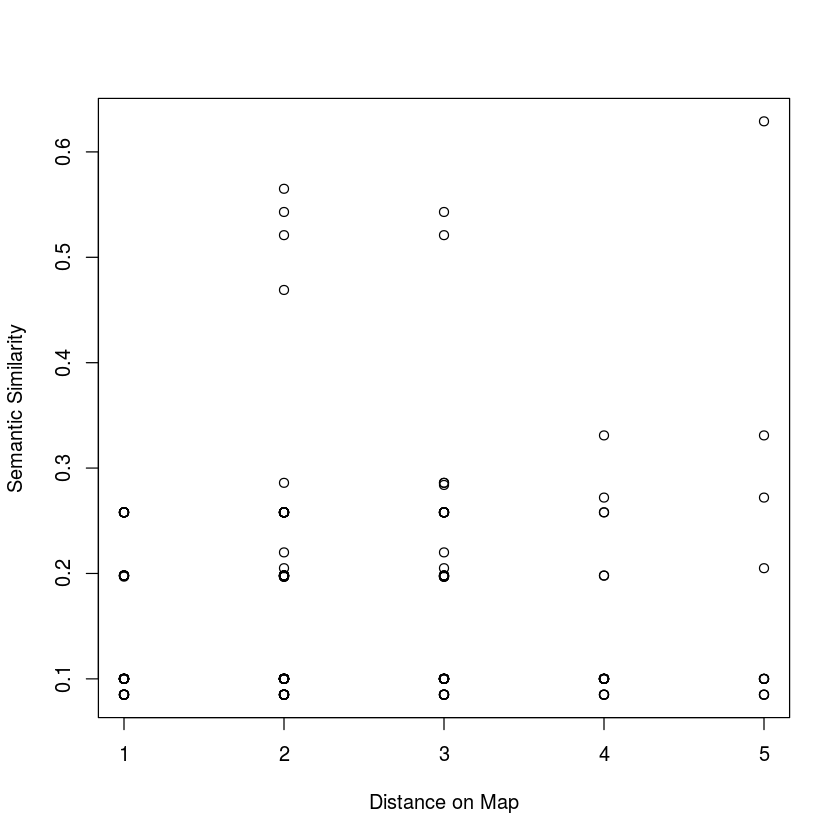

In [48]:
plot(distances, semSims, xlab="Distance on Map", ylab="Semantic Similarity")

In [64]:
cor(distances, semSims)

[1] -0.06938083